#gps_train_predict.ipynb
Minimal example to train a model on subjects 1 and 2 and predict for subject 3.  Forked from the same version for TWristAR.

This is similar to the early work https://github.com/imics-lab/Semi-Supervised-HAR-e4-Wristband/blob/main/Semi-Supervised-HAR.ipynb but uses a much newer version of the loader and is intended to support better assisted labeling.

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

[Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), Texas State University, [IMICS Lab](https://imics.wp.txstate.edu/)  
TODO:
* 



In [1]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip

import pandas as pd
import numpy as np
import urllib.request # to get files from web w/o !wget

# to measure and display training time
import time
from datetime import timedelta

# model library and functions
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping

# for one-hot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
def get_py_file(fname, url):
    """checks for local file, if none downloads from URL.    
    :return: nothing"""
    if (os.path.exists(fname)):
        print ("Local",fname, "found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve(url, filename=fname)

get_py_file(fname = 'load_data_utils.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py')
get_py_file(fname = 'load_data_transforms.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_transforms.py')
get_py_file(fname = 'gesture_phase_segmentation_load_dataset.py', 
                url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/Gesturing_Signing/gesture_phase_segmentation_load_dataset.py')

In [3]:
import load_data_transforms as xform
import load_data_utils as utils
import gesture_phase_segmentation_load_dataset as gps

Local load_data_utils.py found, skipping download
Local load_data_transforms.py found, skipping download


In [4]:
# Use subject 1 & 2 for training (as if they were labeled portions)
# Subject 3 test set will be treated as unlabeled
# adjust samples/window to match TWristAR for code compatibility.
gps.xform.time_steps = 30
gps.xform.stride = 10
subj_dict = dict(train_subj = [1,2],
                valid_subj = [],
                test_subj = [3])
x_train, y_train, x_test, y_test= gps.gesture_phase_segmentation_load_dataset( 
                                split_subj = subj_dict,
                                incl_val_group = False)
print(utils.tabulate_numpy_arrays({'x_train':x_train,'y_train':y_train,
                                   'x_test':x_test,'y_test':y_test}))


Unzipping Gesture Phase Segmentation file in ./gesture_phase_dataset directory
Train: dict_keys(['a1_raw', 'a2_raw', 'a3_raw', 'b1_raw', 'b3_raw'])
Valid: dict_keys([])
Test : dict_keys(['c1_raw', 'c3_raw'])
array    shape          data type
-------  -------------  -----------
x_train  (237, 30, 18)  float32
y_train  (237, 5)       float64
x_test   (251, 30, 18)  float32
y_test   (251, 5)       float64


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [32]:
# additional swizzles to match expected shape
# x_train = np.delete(x_train, -1, axis=2)
# x_test = np.delete(x_test, -1, axis=2)
# print(utils.tabulate_numpy_arrays({'x_train':x_train,'y_train':y_train,
#                                    'x_test':x_test,'y_test':y_test}))

# Build and Train the model using the Subject 1 and 2 labeled data
Note I reduced the kernel size to 8 due to the short nature of the sliding windows.

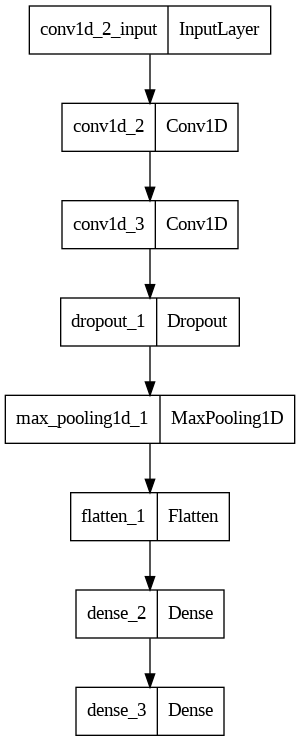

In [6]:
# topology and good article here
# https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
# even though this is an interactive notebook, I've put train and test into
# functions hoping this will make it easier to swap models in the future
def build_1D_CNN():
  n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
  model = keras.Sequential(
    [
      layers.Conv1D(filters=50, kernel_size=5, activation='relu',input_shape=(n_timesteps,n_features)),
      layers.Conv1D(filters=50, kernel_size=5, activation='relu'),
      layers.Dropout(0.5),
      layers.MaxPooling1D(pool_size=2),
      layers.Flatten(),
      layers.Dense(100, activation='relu'),
      layers.Dense(n_outputs, activation='softmax')
        ])
  return model 
model = build_1D_CNN()
# model.summary()
# pass rankdir="LR" to plot_model to display sideways
display(keras.utils.plot_model(model, "my_model.png", show_shapes=False))

In [34]:
def train_1D_CNN(model,
    BATCH_SIZE = 32,    # Typical values are 8, 16 or 32
    NUM_EPOCHS = 20): # Educated guess based on experience with this model and TWristAR
    # see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    history = model.fit(
        x_train,y_train,
        batch_size = BATCH_SIZE,
        epochs=NUM_EPOCHS,
        verbose = 1) #0 = silent, 1 = progress bar, 2 = one line per epoch
    return history
start_time = time.time()
history = train_1D_CNN(model)
end_time = time.time()
train_time = timedelta(seconds=(end_time - start_time))
print('Training time =',(str(train_time).split(".")[0]), 'HH:MM:SS')

Epoch 1/20
8/8 [==============================] - 1s 10ms/step - loss: 2.7243 - accuracy: 0.3840
Epoch 2/20
8/8 [==============================] - 0s 13ms/step - loss: 1.3898 - accuracy: 0.5401
Epoch 3/20
8/8 [==============================] - 0s 11ms/step - loss: 0.9578 - accuracy: 0.6709
Epoch 4/20
8/8 [==============================] - 0s 11ms/step - loss: 0.8412 - accuracy: 0.6920
Epoch 5/20
8/8 [==============================] - 0s 11ms/step - loss: 0.7255 - accuracy: 0.7215
Epoch 6/20
8/8 [==============================] - 0s 10ms/step - loss: 0.7022 - accuracy: 0.7511
Epoch 7/20
8/8 [==============================] - 0s 14ms/step - loss: 0.6045 - accuracy: 0.7890
Epoch 8/20
8/8 [==============================] - 0s 10ms/step - loss: 0.5307 - accuracy: 0.8059
Epoch 9/20
8/8 [==============================] - 0s 10ms/step - loss: 0.4858 - accuracy: 0.8186
Epoch 10/20
8/8 [==============================] - 0s 12ms/step - loss: 0.6349 - accuracy: 0.7300
Epoch 11/20
8/8 [============

In [35]:
#model.save("my_model") # defaults to newer method with more complex format
model.save("my_h5_model.h5") # the .h5 extension changes the way it is saved.

# Predict "unlabeled Subject 3"
Subject 3 data loaded into test set.

In [36]:
model = [] # nuke it!

In [37]:
model = keras.models.load_model("my_h5_model.h5")
predictions = model.predict(x_test, verbose=0,batch_size=32)

#want to use values not one-hot encoding, use argmax to convert
y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
y_test = np.argmax(y_test, axis=-1) # axis=-1 means last axis

# reshape again
y_pred = y_pred.reshape((-1, 1)) # reshape from (__,) to (__,1)
y_test = y_test.reshape((-1, 1)) # reshape from (__,) to (__,1)

In [38]:
# Convert ints back into strings
y_pred = xform.get_ir2_y_string_labels(y_pred, label_map = gps.label_map_gps)
y_test = xform.get_ir2_y_string_labels(y_test, label_map = gps.label_map_gps)

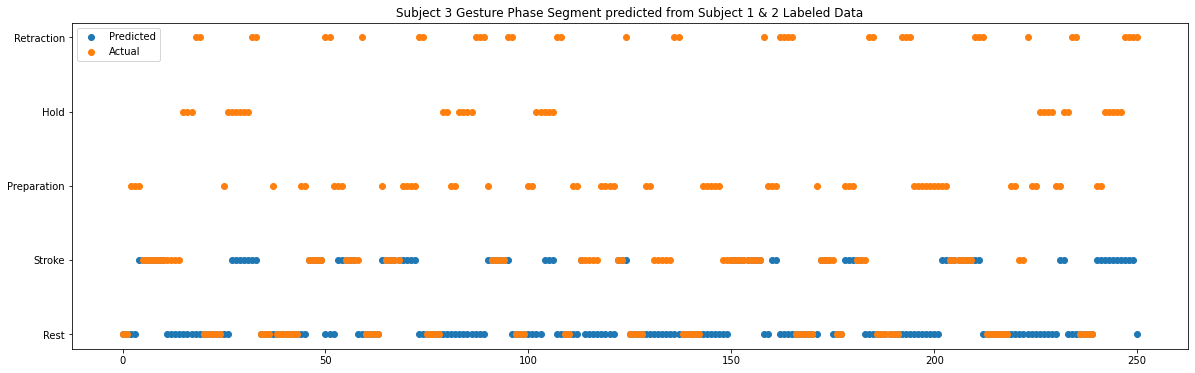

In [39]:
import matplotlib.pyplot as plt
# I never know if better to make a fig and modify or just have commands...
plt.rcParams["figure.figsize"] = (20,6) 
plt.title("Subject 3 Gesture Phase Segment predicted from Subject 1 & 2 Labeled Data")
x_values = range(x_test.shape[0])
plt.scatter(x_values,y_pred[:,0], label="Predicted")
plt.scatter(x_values,y_test[:,0], label = "Actual")
plt.legend(loc="upper left")